<a href="https://colab.research.google.com/github/rika-27/DMT/blob/master/SPAM__HAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def remove_spaces(x): 
  while('' in x) : 
    x.remove('')
  return x

def stems_the_word(word):
  if word.isalpha():
    try:
      if word in ["ü", "Ü"]:
        return stem_dict[ps.stem('u')]
      elif word in ["É","é"]:
        return stem_dict[ps.stem('e')]
      elif word in ["nìte"]:
        return stem_dict[ps.stem('nite')]
      return stem_dict[ps.stem(word.lower())]
    except KeyError:
      return stem_dict[ps.stem('or')]
  else:
    return -10

def pad_me(x):
  zeros_list = np.zeros(39)
  zeros_list[:len(x)] = x
  return zeros_list


ps = PorterStemmer()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


44667 -> 4352
Preparation of the stem dictionary complete!


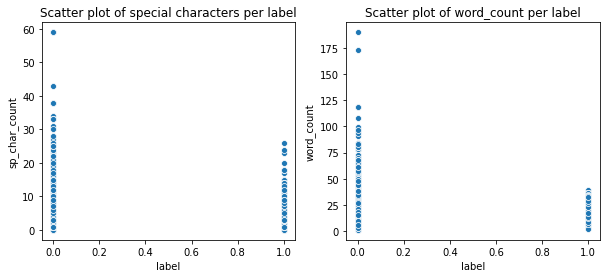

,label,text,sp_char_count,word_count,conv_text
0,0,Go until jurong point crazy Available o,1,1,"[0.0, 0.00022977941176470588, 0.00045955882352..."
1,0,Ok lar Joking wif u oni,1,1,"[0.001608455882352941, 0.001838235294117647, 0..."
2,1,Free entry in 2 a wkly comp to win FA C,1,1,"[0.0029871323529411763, 0.003216911764705882, ..."
3,0,U dun say so early hor U c already then,1,1,"[0.002527573529411765, 0.0055147058823529415, ..."
4,0,Nah I don t think he goes to usf he liv,1,1,"[0.007123161764705882, 0.007352941176470588, 0..."
...,...,...,...,...,...
5569,1,This is the 2nd time we have tried 2 co,1,1,"[0.06939338235294118, 0.01171875, 0.0215992647..."
5570,0,Will ü b going to esplanade fr home,1,1,"[0.023207720588235295, 0.002527573529411765, 0..."
5571,0,Pity was in mood for that So any other,1,1,"[0.9997702205882353, 0.04159007352941176, 0.00..."
5572,0,The guy did some bitching but I acted l,1,1,"[0.021599264705882353, 0.12959558823529413, 0...."


In [0]:
df = pd.read_csv('SmsCollection.csv', sep='Noel')
df.label = pd.factorize(df.label)[0]
df = pd.concat([df, pd.DataFrame({'sp_char_count': df.text.apply(lambda x: [(s.isalpha() or s.isdigit() or s == ' ' ) for s in x].count(False))})], axis=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(df.label, df.sp_char_count, ax=ax1)
ax1.set_title('Scatter plot of special characters per label')
df.text = df.text.str.replace('\W', ' ', regex = True)
df.text = df.text.str.split(' ').apply(lambda x: ' '.join(map(str, remove_spaces(x))))
df = pd.concat([df, pd.DataFrame({'word_count' :df.text.str.split(' ').apply(lambda x: len(x))})], axis = 1)
sns.scatterplot(df.label, df.word_count, ax=ax2)
ax2.set_title('Scatter plot of word_count per label')
df.word_count.loc[df.word_count <= 39] = 1
df.word_count.loc[df.word_count > 1] = 0
df.sp_char_count.loc[df.sp_char_count <= 26] = 1
df.sp_char_count.loc[df.sp_char_count > 1] = 0
df['text'] = df.text.apply(lambda x: x[:39])

unique_words = list(df.text.str.replace('[^a-zA-Z ]', '').str.lower().str.split(' ').sum())
stem = []
for word in unique_words:
  stem.append(ps.stem(word))
stem = list(dict.fromkeys(stem))
print(len(unique_words), '->' ,len(stem))
stem_dict = dict.fromkeys(stem)
for key in stem_dict.keys():
  stem_dict[key] = stem.index(key)
print('Preparation of the stem dictionary complete!')

df = pd.concat([df,pd.DataFrame({'conv_text': df.text.str.split(' ').apply(lambda x: [stems_the_word(word) for word in x])})], axis=1)
# df = pd.concat([df, pd.DataFrame({'number_count': df.conv_text.apply(lambda x: x.count(-10))})], axis = 1)
# sns.scatterplot(df.label, df.number_count, ax=ax3)
# ax3.set_title('Scatter plot of number_count per label')
plt.show()

df['conv_text'] =  df.conv_text.apply(lambda x: pad_me(x))
df['conv_text'] = df.conv_text.apply(lambda x: x / 4352)
df

In [0]:
X_val= df[['sp_char_count', 'word_count']].values
x = df['conv_text'].values
X = []
for i in range(X_val.shape[0]):
  X.append(np.append(X_val[i], x[i][:]))
y = df.label.values
len(X), len(y)


(5574, 5574)

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)
model = MLPClassifier(hidden_layer_sizes=(10, ), activation='relu', solver='adam', alpha=0.0001, max_iter=200,
                      tol=0.0001, beta_1=0.8, beta_2=0.996, epsilon=1e-05, n_iter_no_change=10)

mlp = model.fit(list(X_train), y_train)
y_pred = model.predict(X_test)
print('MLP Test accuracy score', accuracy_score(y_test, y_pred)*100)
y_pred = model.predict(X_train)
print('MLP Train accuracy score', accuracy_score(y_train, y_pred)*100)

dtc = DecisionTreeClassifier(max_depth=14, min_samples_split=7)

dtc.fit(list(X_train), y_train)
y_pred = dtc.predict(X_test)
print('DTC Test accuracy score', accuracy_score(y_test, y_pred)*100)
y_pred = dtc.predict(X_train)
print('DTC Train accuracy score', accuracy_score(y_train, y_pred)*100)


gbc = GradientBoostingClassifier(loss='deviance', n_estimators=180, subsample=.9, min_samples_split=7, max_depth=14)

gbc.fit(list(X_train), y_train)
y_pred = gbc.predict(X_test)
print('GBC Test accuracy score', accuracy_score(y_test, y_pred)*100)
y_pred = gbc.predict(X_train)
print('GBC Train accuracy score', accuracy_score(y_train, y_pred)*100)

# param_grid = {
#     'subsample': [0.8, 0.9, 1, 1.1]
# }
# grid = GridSearchCV(estimator=gbc, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

MLP Test accuracy score 86.3677130044843
MLP Train accuracy score 86.65620094191523
DTC Test accuracy score 90.67264573991032
DTC Train accuracy score 94.66248037676608
GBC Test accuracy score 93.81165919282512
GBC Train accuracy score 100.0


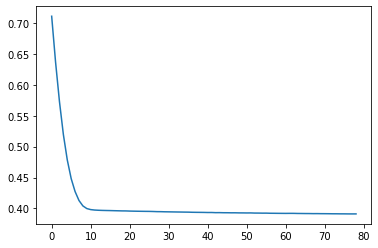

In [0]:
plt.plot(model.loss_curve_)
plt.show()

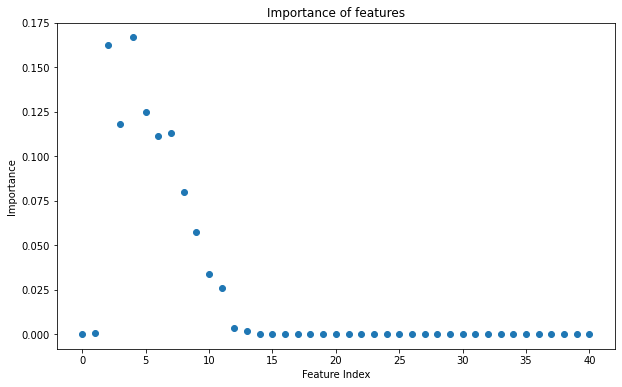

In [0]:
plt.figure(figsize=(10, 6))
plt.scatter(list(range(len(gbc.feature_importances_))), gbc.feature_importances_)
plt.ylabel('Importance')
plt.xlabel('Feature Index')
plt.title('Importance of features')
plt.show()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("MLP Confusion Matrix:")
print(confusion_matrix(y_test, model.predict(X_test)))
print()
print("MLP Classification Report")
print(classification_report(y_test, model.predict(X_test)))

print("DTC Confusion Matrix:")
print(confusion_matrix(y_test, dtc.predict(X_test)))
print()
print("DTC Classification Report")
print(classification_report(y_test, dtc.predict(X_test)))


print("GBC Confusion Matrix:")
print(confusion_matrix(y_test, gbc.predict(X_test)))
print()
print("GBC Classification Report")
print(classification_report(y_test, gbc.predict(X_test)))

y_scores_gb = gbc.decision_function(X_test)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("GBC Area under ROC curve = {:0.2f}".format(roc_auc_gb))

MLP Confusion Matrix:
[[963   0]
 [152   0]]

MLP Classification Report
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       963
           1       0.00      0.00      0.00       152

    accuracy                           0.86      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.86      0.80      1115

DTC Confusion Matrix:
[[943  20]
 [ 84  68]]

DTC Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       963
           1       0.77      0.45      0.57       152

    accuracy                           0.91      1115
   macro avg       0.85      0.71      0.76      1115
weighted avg       0.90      0.91      0.90      1115

GBC Confusion Matrix:
[[954   9]
 [ 60  92]]

GBC Classification Report
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       963
           1       0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
